## import des librairies

In [296]:
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from pathlib import Path
import warnings
from IPython.display import Markdown, display
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Import des données MQL

In [297]:
xlsx_dir = Path("/Users/theonaimbenhellal/Documents/Projet Visual Studio Code/Project/Trading Project/CFD/OPR/xlsx_data")
output_dir = xlsx_dir.parent / "csv_propre"
output_dir.mkdir(exist_ok=True)

def extract_out_transactions(xlsx_path: Path) -> pd.DataFrame:
    df_raw = pd.read_excel(xlsx_path, sheet_name=0, header=None)
    start_row = df_raw[df_raw.iloc[:, 0].astype(str).str.contains("Transactions", na=False)].index[0]
    df = pd.read_excel(xlsx_path, sheet_name=0, skiprows=start_row + 1)
    return df[df["Direction"] == "out"].reset_index(drop=True)

# Boucle sur chaque fichier
for xlsx_file in xlsx_dir.glob("*.xlsx"):
    df_out = extract_out_transactions(xlsx_file)
    
    # Nom de sortie nettoyé
    clean_name = xlsx_file.stem.replace(" ", "_") + "_out.csv"
    output_file = output_dir / clean_name
    
    df_out.to_csv(output_file, index=False)
    print(f"✅ {output_file.name} exporté dans : {output_dir}")

✅ US100_-_2018_2025_-_V1_out.csv exporté dans : /Users/theonaimbenhellal/Documents/Projet Visual Studio Code/Project/Trading Project/CFD/OPR/csv_propre
✅ US500_-_2018_2025_-_V1_out.csv exporté dans : /Users/theonaimbenhellal/Documents/Projet Visual Studio Code/Project/Trading Project/CFD/OPR/csv_propre
✅ US30_-_2018_2025_out.csv exporté dans : /Users/theonaimbenhellal/Documents/Projet Visual Studio Code/Project/Trading Project/CFD/OPR/csv_propre
✅ US500_-_2018_2025_-_V2_out.csv exporté dans : /Users/theonaimbenhellal/Documents/Projet Visual Studio Code/Project/Trading Project/CFD/OPR/csv_propre
✅ US2000_-_2018_2025_out.csv exporté dans : /Users/theonaimbenhellal/Documents/Projet Visual Studio Code/Project/Trading Project/CFD/OPR/csv_propre
✅ US100_-_2018_2025_-_V2_out.csv exporté dans : /Users/theonaimbenhellal/Documents/Projet Visual Studio Code/Project/Trading Project/CFD/OPR/csv_propre


----------

## Recalibrage du risk a notre guise

In [298]:
# === Paramètres globaux (à modifier)
capital_initial = 100000  # capital de départ pour simulation
risk_per_trade_pct = 1   # nouveau risque à tester (%)
risk_per_trade_pct_original = 1.0  # utilisé pour générer le CSV original

# === Calcul du montant de risque
risk_per_trade_eur = capital_initial * (risk_per_trade_pct / 100)
risk_per_trade_eur_original = capital_initial * (risk_per_trade_pct_original / 100)

# === Ratio d’ajustement des profits
risk_scaling_factor = risk_per_trade_eur / risk_per_trade_eur_original

### Résultats de la stratégie 

,Return Net (%),Return Net (€),Winrate (%),Sharpe Ratio,Profit Factor,Avg Monthly Profit (€),Avg Monthly Drawdown (€)
IS,79.64,79640.55,43.18,0.83,1.16,1284.52,6363.41
OOS,49.03,49031.59,40.64,0.82,1.13,1885.83,10794.16
TOTAL,128.67,128672.14,42.42,0.83,1.14,1462.18,7672.49


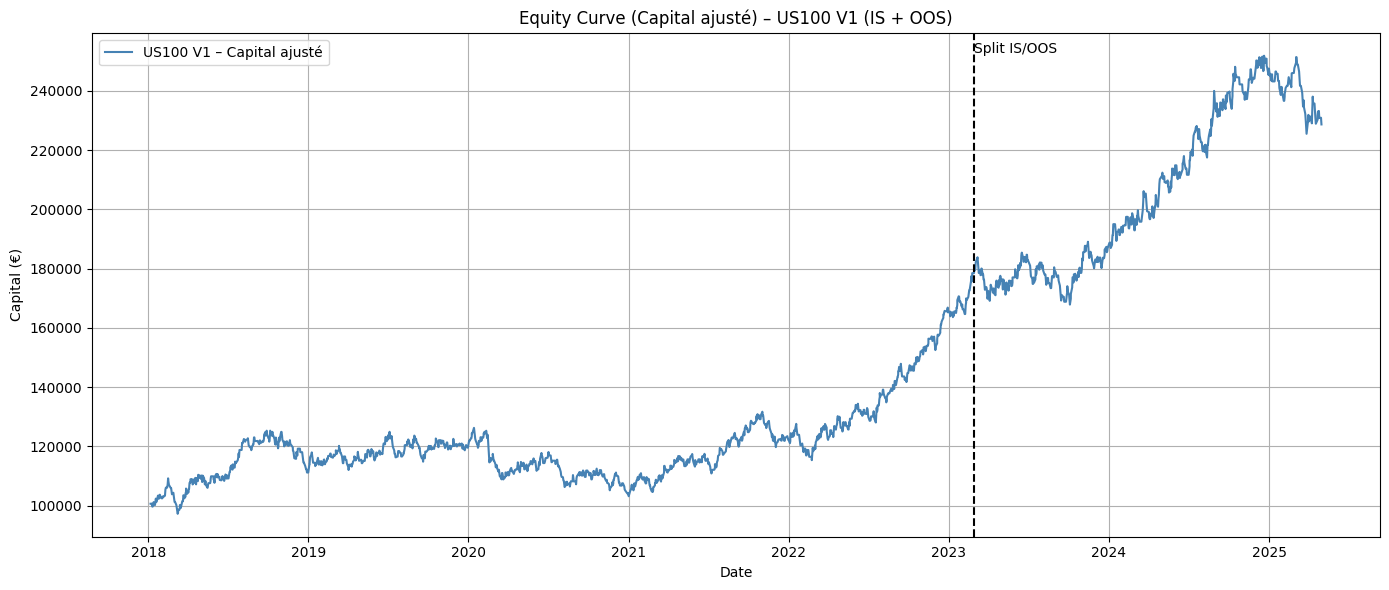

In [299]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Recalcul des profits et du capital ajusté
df_us100["Profit_Adjusted"] = df_us100["Profit"] * risk_scaling_factor
df_us100["cum_pnl"] = df_us100["Profit_Adjusted"].cumsum()
df_us100["capital"] = capital_initial + df_us100["cum_pnl"]

# === Redéfinir split IS/OOS (si nécessaire)
n_split = int(len(df_us100) * 0.7)
split_date = df_us100.loc[n_split, "Heure"]
df_us100["IS/OOS"] = df_us100["Heure"].apply(lambda x: "IS" if x <= split_date else "OOS")
df_is = df_us100[df_us100["IS/OOS"] == "IS"]
df_oos = df_us100[df_us100["IS/OOS"] == "OOS"]

# === Fonction de calcul des métriques
def compute_metrics(df, capital_initial):
    pnl = df["Profit_Adjusted"]
    ret_net_eur = pnl.sum()
    ret_net_pct = 100 * ret_net_eur / capital_initial
    winrate = (pnl > 0).mean() * 100

    daily_returns = df["capital"].pct_change().dropna()
    sharpe_ratio = np.sqrt(252) * daily_returns.mean() / daily_returns.std() if not daily_returns.empty else np.nan

    total_gain = pnl[pnl > 0].sum()
    total_loss = abs(pnl[pnl < 0].sum())
    profit_factor = total_gain / total_loss if total_loss != 0 else np.nan

    df_monthly = df.resample("M", on="Heure").agg({
        "Profit_Adjusted": "sum",
        "capital": ["max", "min"]
    })
    df_monthly.columns = ["monthly_profit", "capital_high", "capital_low"]

    avg_monthly_profit = df_monthly["monthly_profit"].mean()
    avg_monthly_drawdown = (df_monthly["capital_high"] - df_monthly["capital_low"]).mean()

    return {
        "Return Net (%)": round(ret_net_pct, 2),
        "Return Net (€)": round(ret_net_eur, 2),
        "Winrate (%)": round(winrate, 2),
        "Sharpe Ratio": round(sharpe_ratio, 2),
        "Profit Factor": round(profit_factor, 2),
        "Avg Monthly Profit (€)": round(avg_monthly_profit, 2),
        "Avg Monthly Drawdown (€)": round(avg_monthly_drawdown, 2)
    }

# === Calcul des métriques IS / OOS / TOTAL
metrics_is = compute_metrics(df_is.copy(), capital_initial)
metrics_oos = compute_metrics(df_oos.copy(), capital_initial)
metrics_total = compute_metrics(df_us100.copy(), capital_initial)

# === Tableau final
metrics_df = pd.DataFrame([metrics_is, metrics_oos, metrics_total], index=["IS", "OOS", "TOTAL"])
ordered_cols = [
    "Return Net (%)", "Return Net (€)", "Winrate (%)", "Sharpe Ratio",
    "Profit Factor", "Avg Monthly Profit (€)", "Avg Monthly Drawdown (€)"
]
metrics_df = metrics_df[ordered_cols]

# === Affichage tableau
display(metrics_df)

# === Tracé de l'equity curve ajustée
plt.figure(figsize=(14, 6))
plt.plot(df_us100["Heure"], df_us100["capital"], label="US100 V1 – Capital ajusté", color="steelblue")
plt.axvline(split_date, color="black", linestyle="--", linewidth=1.5)
plt.text(split_date, df_us100["capital"].max(), "Split IS/OOS", color="black", fontsize=10, ha="left", va="bottom")

plt.title("Equity Curve (Capital ajusté) – US100 V1 (IS + OOS)")
plt.xlabel("Date")
plt.ylabel("Capital (€)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

---------

## Simulation des stop Mensuel ( je me stops a X % de gains)

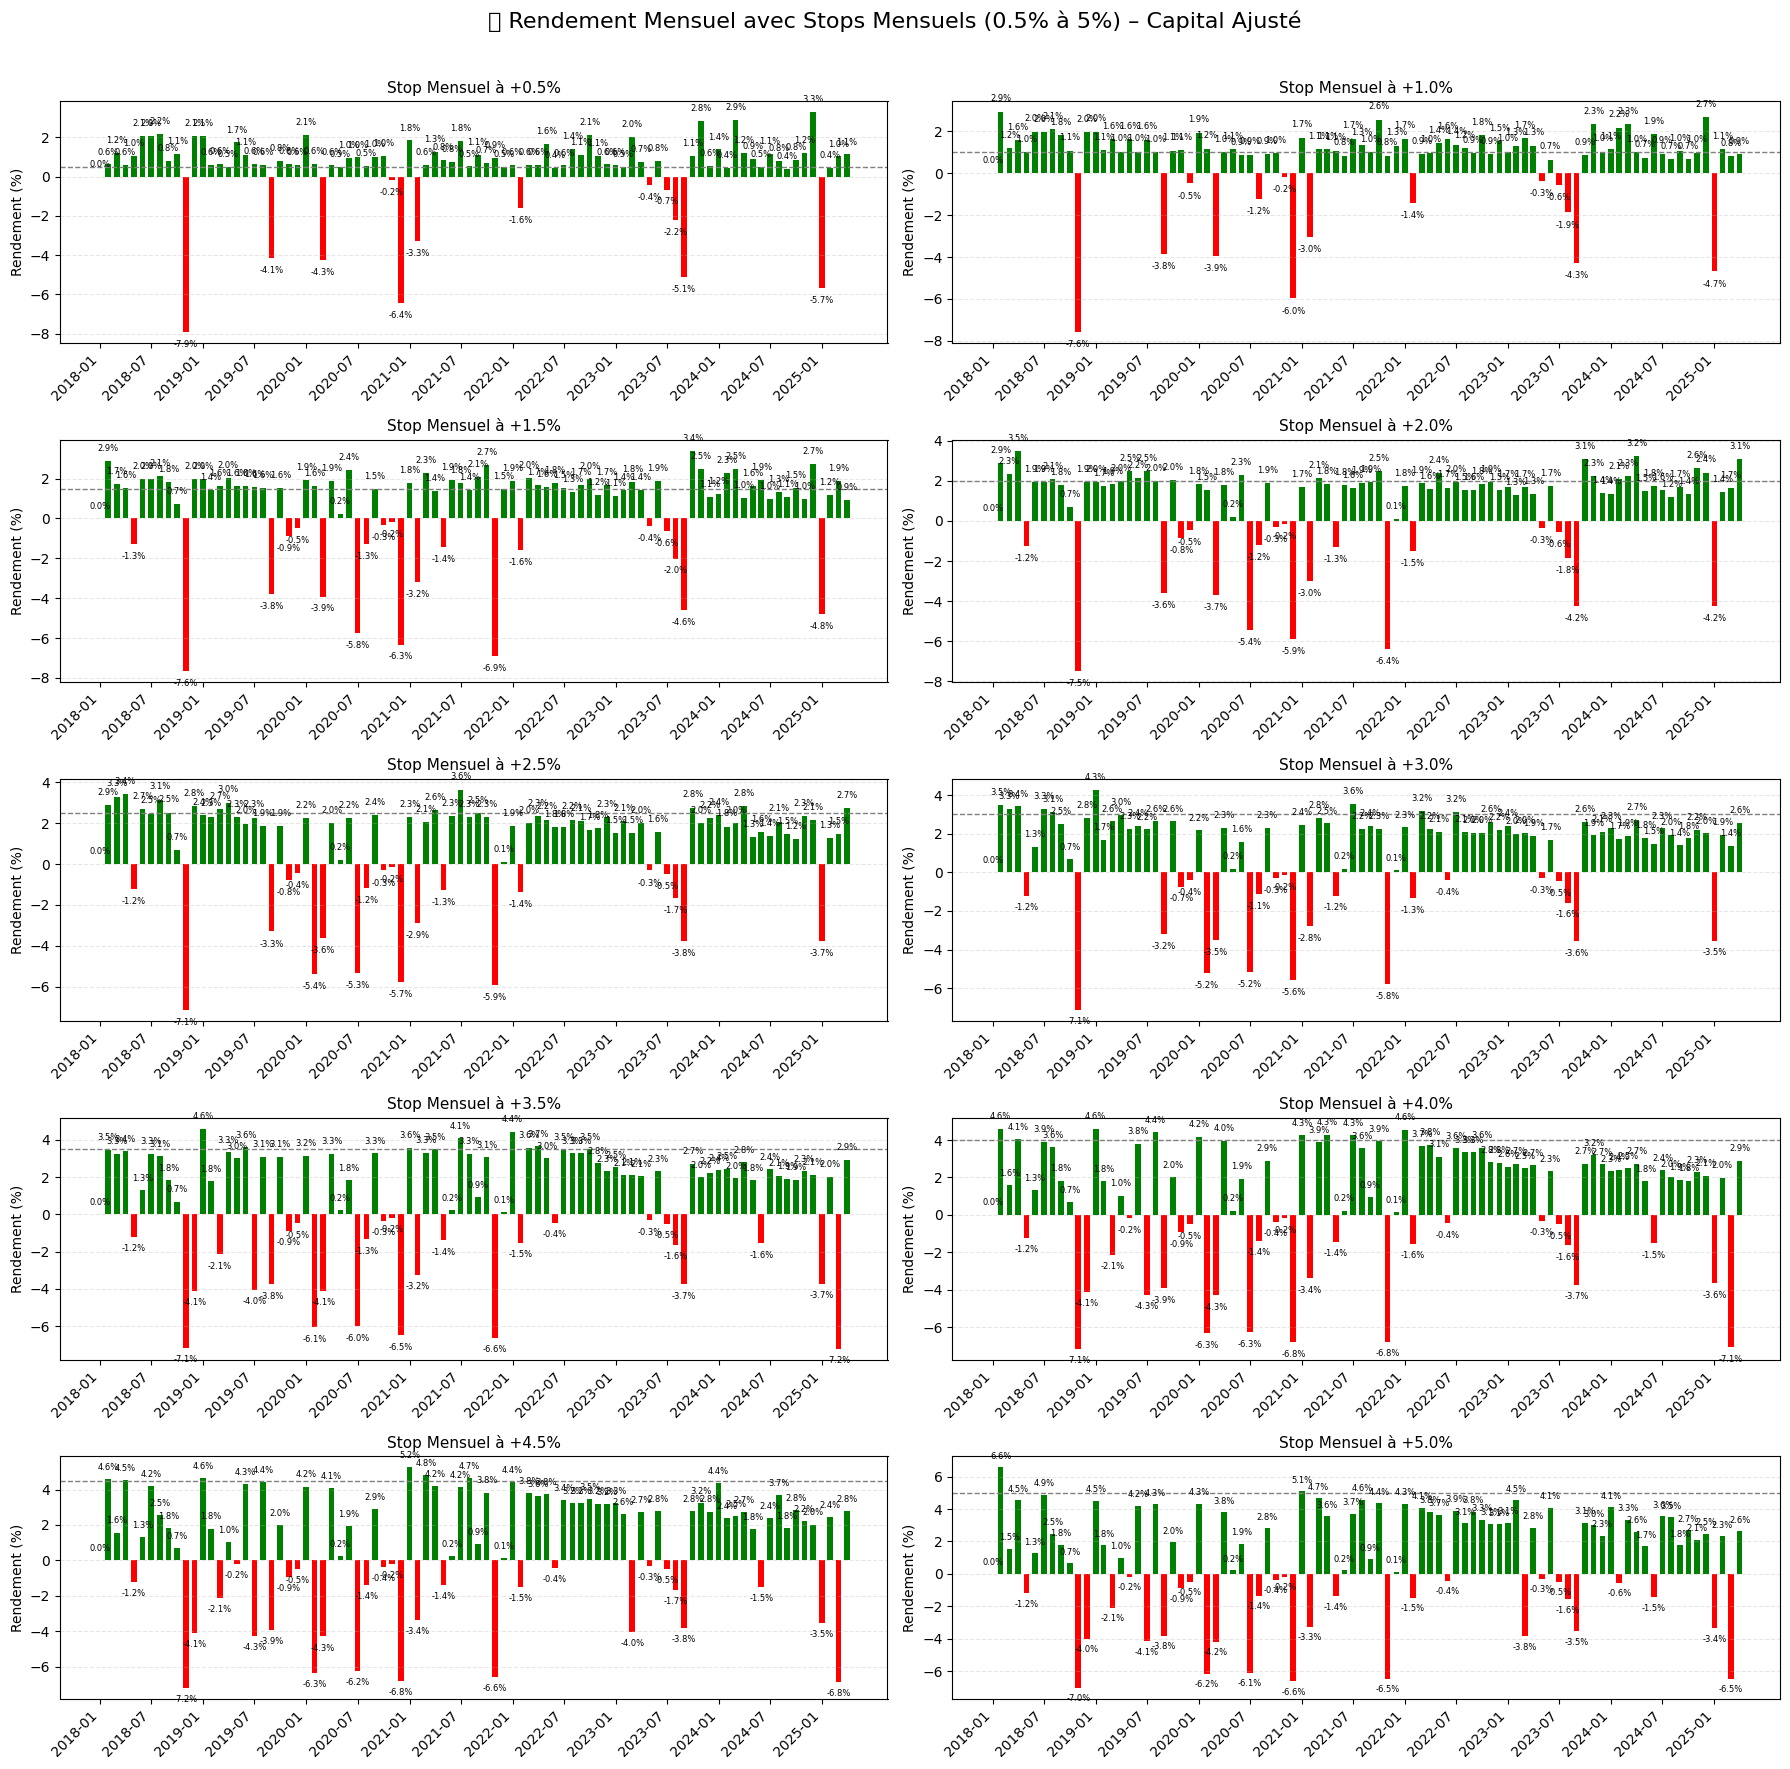

In [300]:
import matplotlib.pyplot as plt

# === Simulation du stop mensuel sur rendements journaliers ajustés
def simulate_stop_monthly(pnl_series, stop_pct, capital_initial=100_000):
    # S'assurer que l'index est bien de type datetime
    if not pd.api.types.is_datetime64_any_dtype(pnl_series.index):
        raise ValueError("L'index de la série PnL doit être de type datetime.")
    
    simulated = []
    current_month = None
    monthly_pnl = 0.0
    trading_active = True

    for date, pnl in pnl_series.items():
        month = date.to_period("M")
        if month != current_month:
            current_month = month
            monthly_pnl = 0.0
            trading_active = True

        if trading_active:
            simulated.append(pnl)
            monthly_pnl += pnl
            if monthly_pnl >= (capital_initial * stop_pct / 100):
                trading_active = False
        else:
            simulated.append(0.0)

    simulated = pd.Series(simulated, index=pnl_series.index)
    capital = simulated.cumsum() + capital_initial
    monthly_returns = capital.resample("M").last().pct_change().fillna(0) * 100
    return monthly_returns

# === Préparer la série PnL ajustée avec index datetime
pnl_adjusted = df_us100.copy()
pnl_adjusted = pnl_adjusted.set_index("Heure")  # s'assurer que l'index est datetime
pnl_series = pnl_adjusted["Profit_Adjusted"]

# === Définir les seuils à tester : 0.5 à 5% par pas de 0.5
stop_thresholds = [round(x * 0.5, 1) for x in range(1, 11)]

# === Générer les simulations et afficher sous forme de graphiques
fig, axes = plt.subplots(5, 2, figsize=(18, 18))
axes = axes.flatten()

for i, stop in enumerate(stop_thresholds):
    monthly_returns = simulate_stop_monthly(pnl_series, stop_pct=stop, capital_initial=capital_initial)

    colors = ["green" if v >= 0 else "red" for v in monthly_returns]
    labels_months = [d.strftime("%Y-%m") for d in monthly_returns.index]

    ax = axes[i]
    bars = ax.bar(monthly_returns.index, monthly_returns, color=colors, width=20)
    for b, v in zip(bars, monthly_returns):
        ax.text(b.get_x() + b.get_width()/2, v + (0.4 if v >= 0 else -0.4), f"{v:.1f}%",
                ha="center", va="bottom" if v >= 0 else "top", fontsize=6)

    ax.axhline(stop, color="gray", linestyle="--", linewidth=1)
    ax.set_title(f"Stop Mensuel à +{stop:.1f}%", fontsize=11)
    ax.set_ylabel("Rendement (%)")
    ax.set_xticks(monthly_returns.index[::6])
    ax.set_xticklabels(labels_months[::6], rotation=45, ha="right")
    ax.grid(axis="y", linestyle="--", alpha=0.3)

plt.suptitle("📊 Rendement Mensuel avec Stops Mensuels (0.5% à 5%) – Capital Ajusté", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

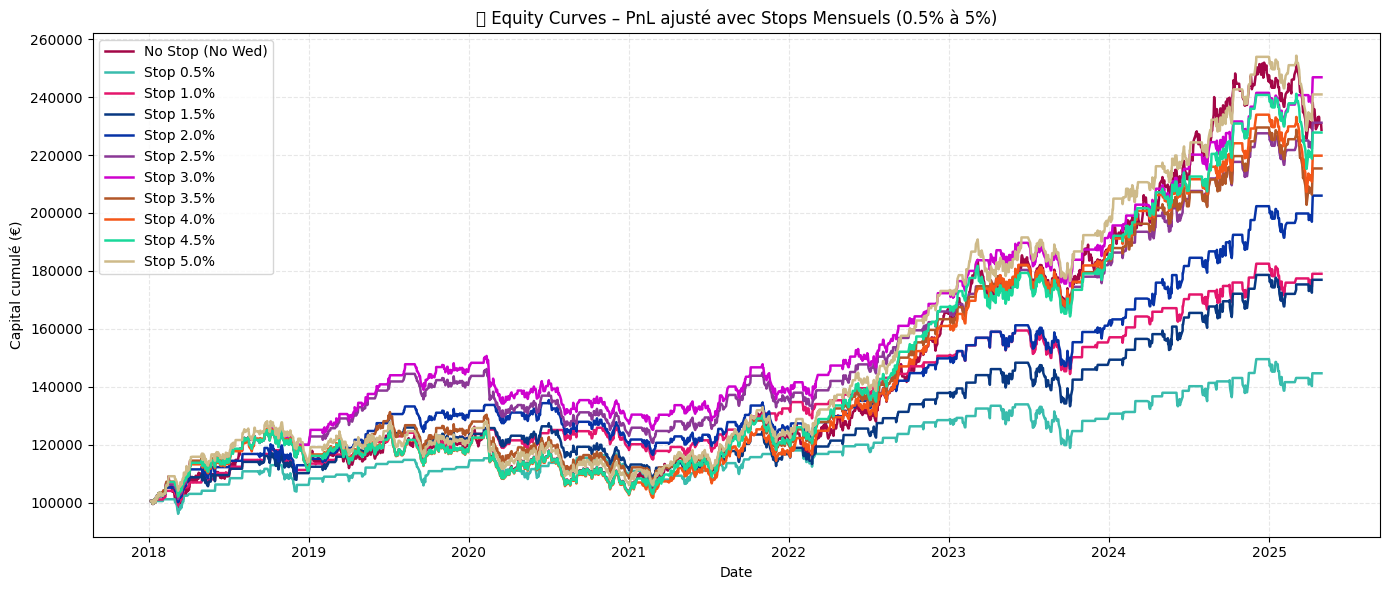


📊 Tableau comparatif des performances :


,Strategy,ReturnNet($),Sharpe,MaxDrawdown(%),R2_Equity,AvgMonthlyReturn(%),AvgMonthlyDrawdown(%)
0,Stop 3.0%,145173.74,1.21,-0.17,-17.82,1.03,-2.49
1,Stop 2.5%,129602.33,1.13,-0.17,-20.94,0.96,-2.66
2,Stop 5.0%,139298.13,0.99,-0.17,-10.89,1.04,-2.77
3,Stop 2.0%,104628.91,0.96,-0.14,-29.57,0.83,-2.68
4,Stop 4.5%,126244.54,0.91,-0.18,-12.12,0.98,-2.95
5,Stop 3.5%,113935.10,0.90,-0.19,-14.95,0.89,-2.96
6,Stop 4.0%,118323.01,0.89,-0.19,-12.45,0.93,-2.93
7,Stop 1.0%,77854.79,0.88,-0.09,-38.42,0.67,-2.81
8,No Stop (No Wed),127161.49,0.83,-0.18,-10.56,0.99,-2.67
9,Stop 1.5%,75798.80,0.76,-0.15,-41.83,0.66,-2.87


In [301]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# === Fonction de simulation d'equity avec stop mensuel ===
def simulate_equity_stop_monthly(pnl_series, stop_pct, capital_initial=100_000):
    simulated = []
    current_month = None
    monthly_pnl = 0.0
    trading_active = True

    for date, pnl in pnl_series.items():
        month = date.to_period("M")
        if month != current_month:
            current_month = month
            monthly_pnl = 0.0
            trading_active = True

        if trading_active:
            simulated.append(pnl)
            monthly_pnl += pnl
            if monthly_pnl >= (capital_initial * stop_pct / 100):
                trading_active = False
        else:
            simulated.append(0.0)

    simulated = pd.Series(simulated, index=pnl_series.index)
    equity = simulated.cumsum() + capital_initial
    return equity

# === Fonction pour calculer les métriques
def compute_metrics_from_port_rets(port_rets, initial_capital=100_000):
    mu = port_rets.mean()
    sigma = port_rets.std()
    sharpe = (mu / sigma * np.sqrt(252)) if sigma > 0 else np.nan
    eq = (1 + port_rets).cumprod() * initial_capital
    return_net = eq.iloc[-1] - initial_capital
    max_drawdown = ((eq - eq.cummax()) / eq.cummax()).min()
    x = eq.index.values.astype(np.int64) / 1e9
    y = eq.values
    x_c, y_c = x - x.mean(), y - y.mean()
    ss_tot = np.sum(y_c ** 2)
    r2 = 1 - np.sum((y - np.poly1d(np.polyfit(x_c, y_c, 1))(x_c)) ** 2) / ss_tot if ss_tot > 0 else np.nan
    monthly = eq.resample("M").last().pct_change().dropna()
    avg_ret = monthly.mean() * 100
    avg_dd = monthly[monthly < 0].mean() * 100 if not monthly[monthly < 0].empty else 0
    return sharpe, return_net, max_drawdown, r2, avg_ret, avg_dd, eq

# === Données de base : PnL ajusté avec index datetime
# Remplace ceci par ta propre série si besoin
pnl_series = df_us100.copy().set_index("Heure")["Profit_Adjusted"]

# === Courbe de base sans stop mensuel
equity_curves = {"No Stop (No Wed)": pnl_series.cumsum() + capital_initial}

# === Simulations pour stops de 0.5% à 5% par pas de 0.5
stop_levels = [round(0.5 * i, 1) for i in range(1, 11)]
for stop_pct in stop_levels:
    eq = simulate_equity_stop_monthly(pnl_series, stop_pct, capital_initial=capital_initial)
    equity_curves[f"Stop {stop_pct}%"] = eq

# === Couleurs aléatoires
random.seed(42)
colors = {label: [random.random() for _ in range(3)] for label in equity_curves}

# === Affichage des equity curves
plt.figure(figsize=(14, 6))
for label, eq in equity_curves.items():
    plt.plot(eq, label=label, linewidth=1.8, color=colors[label])

plt.title("📈 Equity Curves – PnL ajusté avec Stops Mensuels (0.5% à 5%)")
plt.xlabel("Date")
plt.ylabel("Capital cumulé (€)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

# === Calcul et affichage tableau
summary = []
for name, eq in equity_curves.items():
    s, rn, dd, r2, avg_ret, avg_dd, _ = compute_metrics_from_port_rets(eq.pct_change().dropna())
    summary.append({
        "Strategy": name,
        "ReturnNet($)": round(rn, 2),
        "Sharpe": round(s, 2),
        "MaxDrawdown(%)": round(dd, 2),
        "R2_Equity": round(r2, 2),
        "AvgMonthlyReturn(%)": round(avg_ret, 2),
        "AvgMonthlyDrawdown(%)": round(avg_dd, 2)
    })

df_summary = pd.DataFrame(summary)
df_summary = df_summary.sort_values("Sharpe", ascending=False).reset_index(drop=True)

# === Affichage tableau
print("\n📊 Tableau comparatif des performances :")
from IPython.display import display
display(df_summary)

------

In [318]:
capital_initial = 100_000        # capital de départ
risk_per_trade_pct = 1         # risque par trade (%)
risk_per_trade_pct_original = 1.0
monthly_stop_gain_pct = 1.5     # stop gain mensuel (%) à définir manuellement

In [319]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from tqdm import tqdm

# === Calcul scaling des rendements
risk_per_trade_eur = capital_initial * (risk_per_trade_pct / 100)
risk_per_trade_eur_original = capital_initial * (risk_per_trade_pct_original / 100)
risk_scaling_factor = risk_per_trade_eur / risk_per_trade_eur_original

# === Paramètres FTMO
rules_phase1 = {
    "target": 10_000,
    "max_total_loss": 10_000,
    "max_daily_loss": 5_000,
    "min_days": 4
}
rules_phase2 = {
    "target": 5_000,
    "max_total_loss": 10_000,
    "max_daily_loss": 5_000,
    "min_days": 4
}

# === Fonction de simulation avec Stop Mensuel Gain
def run_ftmo_simulation(rets_array, phase1, phase2, capital_initial=100_000, n_simulations=20000):
    n_steps = len(rets_array)
    funded_success, funded_fail = 0, 0
    days_all = []
    reasons_counter = {k: 0 for k in [
        "phase1_dd", "phase1_daily", "phase1_no_target",
        "phase2_dd", "phase2_daily", "phase2_no_target"
    ]}

    for _ in tqdm(range(n_simulations), desc="Simulating FTMO Challenge + Monthly Gain Stop"):
        equity = capital_initial
        peak_equity = capital_initial
        sampled = np.random.choice(rets_array, size=n_steps, replace=True)
        violated = False

        # Phase 1
        current_month = 0
        monthly_pnl = 0.0
        trading_active = True

        for t1 in range(n_steps):
            month = t1 // 21
            if month != current_month:
                current_month = month
                monthly_pnl = 0.0
                trading_active = True

            if not trading_active:
                continue

            r = sampled[t1]
            daily_loss = -capital_initial * r if r < 0 else 0
            equity *= (1 + r)
            monthly_pnl += r

            if daily_loss > phase1["max_daily_loss"]:
                reasons_counter["phase1_daily"] += 1
                violated = True
                break
            peak_equity = max(peak_equity, equity)
            if (peak_equity - equity) > phase1["max_total_loss"]:
                reasons_counter["phase1_dd"] += 1
                violated = True
                break
            if equity >= capital_initial + phase1["target"] and t1 + 1 >= phase1["min_days"]:
                break
            if monthly_pnl >= (monthly_stop_gain_pct / 100):
                trading_active = False

        else:
            reasons_counter["phase1_no_target"] += 1
            violated = True

        if violated:
            funded_fail += 1
            continue

        # Phase 2
        peak_equity = equity
        current_month = t1 // 21
        monthly_pnl = 0.0
        trading_active = True

        for t2 in range(t1 + 1, n_steps):
            month = t2 // 21
            if month != current_month:
                current_month = month
                monthly_pnl = 0.0
                trading_active = True

            if not trading_active:
                continue

            r = sampled[t2]
            daily_loss = -equity * r if r < 0 else 0
            equity *= (1 + r)
            monthly_pnl += r

            if daily_loss > phase2["max_daily_loss"]:
                reasons_counter["phase2_daily"] += 1
                violated = True
                break
            peak_equity = max(peak_equity, equity)
            if (peak_equity - equity) > phase2["max_total_loss"]:
                reasons_counter["phase2_dd"] += 1
                violated = True
                break
            if equity >= capital_initial + phase1["target"] + phase2["target"] and (t2 - t1) >= phase2["min_days"]:
                days_all.append(t2 + 1)
                funded_success += 1
                break
            if monthly_pnl >= (monthly_stop_gain_pct / 100):
                trading_active = False

        else:
            reasons_counter["phase2_no_target"] += 1
            funded_fail += 1

    return funded_success, funded_fail, np.array(days_all), reasons_counter


Simulating FTMO Challenge + Monthly Gain Stop: 100%|██████████| 20000/20000 [00:03<00:00, 5190.30it/s]



### 📊 Résultats FTMO – **eq_1_5 – Risk 1.0%, Stop mensuel 1.5%** (18,903 simulations)

✅ **Comptes funded validés** : 16,899  
❌ **Comptes échoués** : 2,004  
➗ **Proportion réussite / échec** : 89.40% / 10.60%  
⏱️ **Temps moyen (succès)** : 454.1 jours

📈 **Statistiques « jours pour réussir » (pour les 16,899 succès)** :  
• Q1 (25%) : 295.0 jours  
• Médiane : 407.0 jours  
• Q3 (75%) : 569.0 jours

✅ 0.00% en ≤ 30 jours  
✅ 0.00% en ≤ 60 jours  
✅ 0.01% en ≤ 90 jours  
⌛ 99.99% en > 90 jours

📉 **Causes des échecs** :
• 📉 Phase 1 – Max Drawdown     : 2002
• 💥 Phase 1 – Daily Loss       : 0
• ⏱️ Phase 1 – Target non atteint : 1

• 📉 Phase 2 – Max Drawdown     : 1097
• 💥 Phase 2 – Daily Loss       : 0
• ⏱️ Phase 2 – Target non atteint : 1


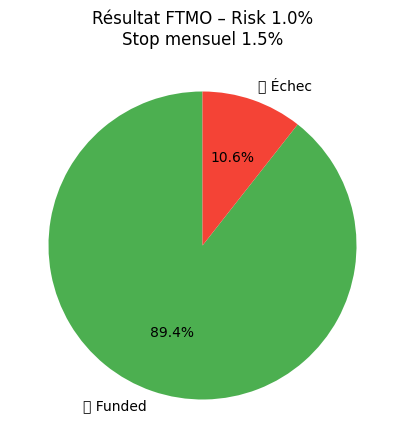

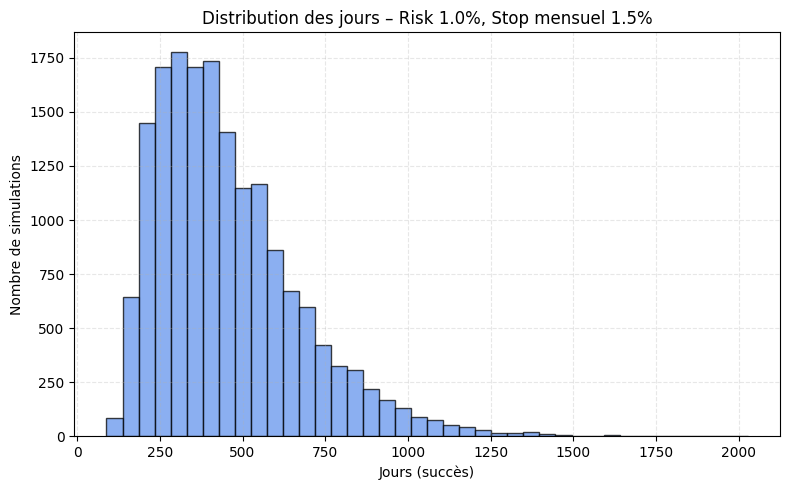

In [320]:
# === Lancer la simulation
rets = eq_1_5.pct_change().dropna().values * risk_scaling_factor
success, fail, days, reasons = run_ftmo_simulation(rets, rules_phase1, rules_phase2, capital_initial)

# === Résumé Markdown
res = format_result(
    f"eq_1_5 – Risk {risk_per_trade_pct:.1f}%, Stop mensuel {monthly_stop_gain_pct:.1f}%",
    success, fail, days, reasons
)
display(Markdown(res))

# === Camembert
plt.figure(figsize=(5, 5))
plt.pie([success, fail], labels=["✅ Funded", "❌ Échec"],
        autopct="%1.1f%%", startangle=90, colors=["#4CAF50", "#F44336"])
plt.title(f"Résultat FTMO – Risk {risk_per_trade_pct:.1f}%\nStop mensuel {monthly_stop_gain_pct:.1f}%")
plt.show()

# === Histogramme des jours
plt.figure(figsize=(8, 5))
plt.hist(days, bins=40, color="cornflowerblue", edgecolor="black", alpha=0.75)
plt.title(f"Distribution des jours – Risk {risk_per_trade_pct:.1f}%, Stop mensuel {monthly_stop_gain_pct:.1f}%")
plt.xlabel("Jours (succès)")
plt.ylabel("Nombre de simulations")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

-------

## Simulation FTMO sous Drawdown

In [335]:
equity_us100 = eq_1_5  # Ou la bonne série correspondant à ta stratégie réelle

# === Paramètres globaux
capital_start = 9150  # Equity actuelle
capital_target = 10000    # Objectif de récupération
capital_min = 9000       # Échec si ce niveau est atteint
n_simulations = 10000
risk_pct = 0.5           # Risque testé (% du capital)

Simulating recovery from drawdown: 100%|██████████| 10000/10000 [00:00<00:00, 10765.50it/s]



### 🎯 Simulation de remontée de drawdown (Risk 0.5%, 10,000 runs)

✅ Succès (remontée à 80K) : **6,928 → 69.28%**  
❌ Échec (perte jusqu'à 72K) : **3,072 → 30.72%**

📊 Jours moyens pour remonter : **433.1 jours**


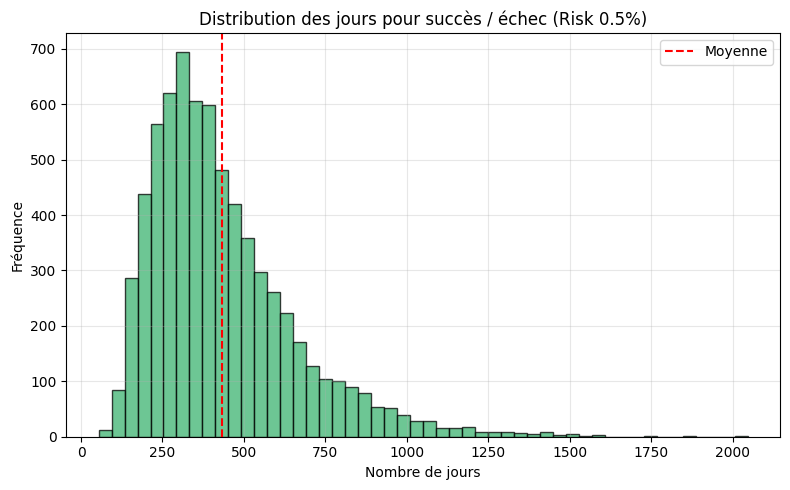

In [336]:
# === Extraire les rendements depuis ta stratégie réelle (à adapter)
# equity_us100 = pd.Series(...)  # Ta vraie courbe equity ici
rets_base = equity_us100.pct_change().dropna()
rets_scaled = rets_base.values * (risk_pct / 1.0)

# === Fonction de simulation
def simulate_recovery(rets_scaled, capital_start, capital_target, capital_min, n_sim=10000):
    success, fail = 0, 0
    days_success = []

    for _ in tqdm(range(n_sim), desc="Simulating recovery from drawdown"):
        capital = capital_start
        sampled = np.random.choice(rets_scaled, size=3000, replace=True)  # long enough horizon

        for i, r in enumerate(sampled):
            capital *= (1 + r)
            if capital >= capital_target:
                success += 1
                days_success.append(i + 1)
                break
            elif capital <= capital_min:
                fail += 1
                break

    return success, fail, np.array(days_success)

# === Exécution
success, fail, days_success = simulate_recovery(rets_scaled, capital_start, capital_target, capital_min, n_simulations)

# === Affichage résultat
total = success + fail
pct_success = success / total * 100
pct_fail = fail / total * 100
avg_days = np.mean(days_success) if len(days_success) > 0 else np.nan

display(Markdown(f"""
### 🎯 Simulation de remontée de drawdown (Risk {risk_pct:.1f}%, {n_simulations:,} runs)

✅ Succès (remontée à 80K) : **{success:,} → {pct_success:.2f}%**  
❌ Échec (perte jusqu'à 72K) : **{fail:,} → {pct_fail:.2f}%**

📊 Jours moyens pour remonter : **{avg_days:.1f} jours**
"""))

# === Histogramme
plt.figure(figsize=(8, 5))
plt.hist(days_success, bins=50, color="mediumseagreen", edgecolor="black", alpha=0.75)
plt.axvline(avg_days, color='red', linestyle='--', label='Moyenne')
plt.title(f"Distribution des jours pour succès / échec (Risk {risk_pct:.1f}%)")
plt.xlabel("Nombre de jours")
plt.ylabel("Fréquence")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()